In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import io
from sklearn.linear_model import LinearRegression



In [4]:
url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
download = requests.get(url).content
vix_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
vix_df.rename(columns={'CLOSE': 'VIX'}, inplace=True)
vix_df.rename(columns={'DATE': 'date'}, inplace=True)
vix_df = vix_df[['date', 'VIX']]
vix_df['date'] = pd.to_datetime(vix_df['date'])
vix_df['VIX'] = vix_df['VIX'].astype(float)
vix_df.head()

,date,VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [5]:
def generate_ou_paths(S0, mu, theta, sigma, T, dt, n_simulations):
    n_steps = int(T / dt)
    paths = np.zeros((n_steps + 1, n_simulations))
    paths[0] = S0
    for t in range(1, n_steps + 1):
        dW = np.random.normal(scale=np.sqrt(dt), size=n_simulations)
        paths[t] = paths[t - 1] + theta * (mu - paths[t - 1]) * dt + sigma * dW
        min_vix_value = 10
        paths[t] = np.clip(paths[t - 1] + theta * (mu - paths[t - 1]) * dt + sigma * dW, min_vix_value, None)
    return paths

           0          1          2       date
0  20.000000  20.000000  20.000000 1990-01-02
1  19.229486  20.034712  19.969168 1990-01-03
2  19.387574  20.523410  21.564021 1990-01-04
3  18.648048  20.549303  20.690454 1990-01-05
4  18.895090  20.494451  19.746091 1990-01-08


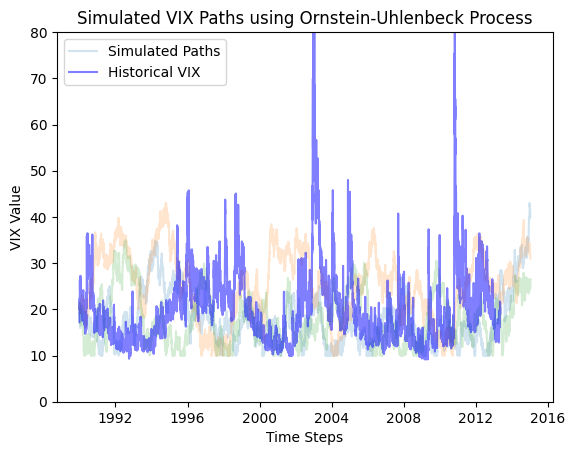

In [6]:
#  Example usage
np.random.seed() # For reproducible results
S0 = 20  # Initial VIX value, can be the latest value from your historical data
mu = 20  # Long-term mean of VIX
theta = 0.5  # Speed of mean reversion
sigma = 10  # Volatility
T = 25  # Time horizon in years
dt = 1/252  # Daily time step
n_simulations = 3  # Number of simulated paths
simulated_paths = generate_ou_paths(S0, mu, theta, sigma, T, dt, n_simulations)
paths_df = pd.DataFrame(simulated_paths)
paths_df['date'] = vix_df['date']
print(paths_df.head())
# Plot simulated paths
date_range = pd.date_range(start=vix_df['date'][0], periods=len(vix_df), freq='D')
for i in range(n_simulations):
    plt.plot(paths_df['date'],simulated_paths[:, i], alpha=0.2,  label='Simulated Paths' if i == 0 else None)
plt.xlabel('Time Steps')
plt.ylabel('VIX Value')
plt.ylim(0, 80)
plt.title('Simulated VIX Paths using Ornstein-Uhlenbeck Process')

# Add historical data to the plot
plt.plot(date_range, vix_df['VIX'], color='blue', label='Historical VIX', alpha=0.5)
plt.legend()
plt.show()

In [7]:
def estimate_ou_parameters(vix_df, dt=1/252):
    """
    Estimate parameters of the Ornstein-Uhlenbeck process from VIX historical data.

    :param vix_df: Historical VIX data (numpy array or Pandas series)
    :param dt: Time step (default is daily for 252 trading days in a year)
    :return: Tuple of (mu, theta, sigma)
    """
    # Calculate differences
    delta_X = np.diff(vix_df)
    X_lagged = vix_df[:-1]

    # Linear regression
    model = LinearRegression().fit(X_lagged.reshape(-1, 1), delta_X)
    b = model.coef_[0]
    a = model.intercept_

    # Solving for mu and theta
    theta = -b / dt
    mu = a / (theta * dt)

    # Estimate sigma
    residuals = delta_X - (a + b * X_lagged)
    sigma = np.std(residuals) / np.sqrt(dt)

    return mu, theta, sigma

mu, theta, sigma = estimate_ou_parameters(vix_df['VIX'].values)
print(f"Estimated parameters: mu = {mu}, theta = {theta}, sigma = {sigma}")


Estimated parameters: mu = 19.62941534930703, theta = 5.423693469595827, sigma = 25.927865986491984


           0       date
0  20.000000 1990-01-02
1  18.293353 1990-01-03
2  15.034099 1990-01-04
3  14.733208 1990-01-05
4  13.487487 1990-01-08


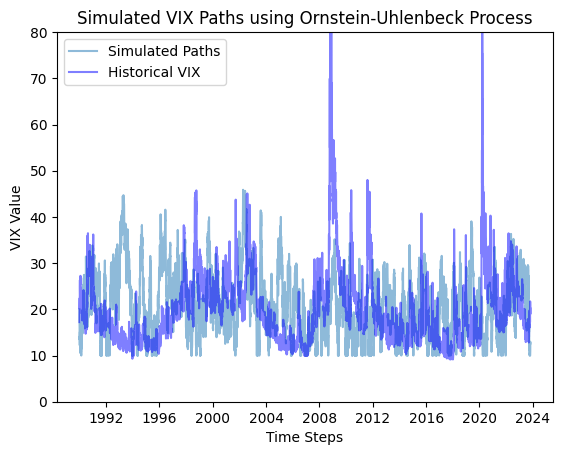

In [8]:
# Generate paths
np.random.seed() # For reproducible results
S0 = 20  # Initial VIX value, can be the latest value from your historical data
T = 35  # Time horizon in years
dt = 1/252  # Daily time step
n_simulations = 1  # Number of simulated paths
simulated_paths = generate_ou_paths(S0, mu, theta, sigma, T, dt, n_simulations)
paths_df = pd.DataFrame(simulated_paths)
paths_df['date'] = vix_df['date']
min_vix_value = 10

print(paths_df.head())

# Plot simulated paths
date_range = pd.date_range(start=vix_df['date'][0], periods=len(vix_df), freq='D')

for i in range(n_simulations):
    plt.plot(paths_df['date'],simulated_paths[:, i], alpha=0.5,  label='Simulated Paths' if i == 0 else None)
plt.xlabel('Time Steps')
plt.ylabel('VIX Value')
plt.ylim(0, 80)
plt.title('Simulated VIX Paths using Ornstein-Uhlenbeck Process')

# Add historical data to the plot
plt.plot(vix_df['date'], vix_df['VIX'], color='blue', label='Historical VIX', alpha=0.5)
plt.legend()

plt.show()

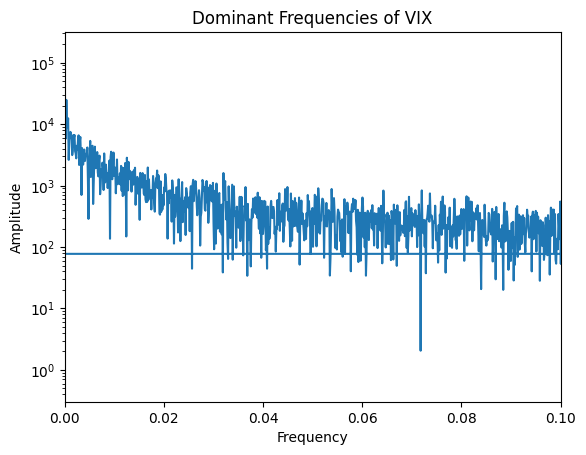

In [9]:
vix_fft = np.fft.fft(vix_df['VIX'].values)

# Get frequencies
n = len(vix_fft)
freq = np.fft.fftfreq(n)

# Plot dominant frequencies
plt.plot(freq, np.abs(vix_fft))
plt.xlim(0, 0.1)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.title('Dominant Frequencies of VIX')
plt.show()


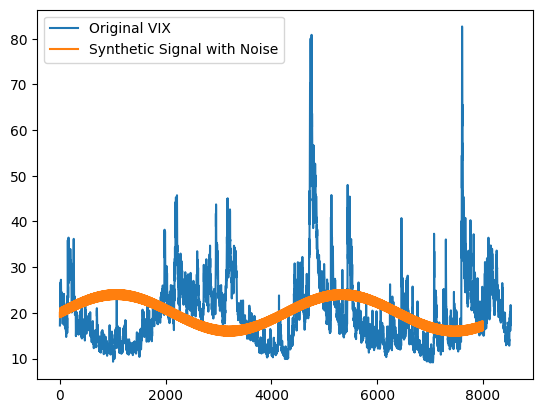

In [10]:
import numpy as np
# import matplotlib.pyplot as plt

# Generate a synthetic VIX data for demonstration (replace with your VIX data)
vix_data = vix_df['VIX'].values

# Apply FFT
vix_fft = np.fft.fft(vix_data)
frequencies = np.fft.fftfreq(len(vix_fft))

# Identify main frequency (for simplicity, we just find the maximum)
main_frequency = frequencies[np.argmax(np.abs(vix_fft[1:]) + 1)]  # Excluding the 0 frequency

# Create a synthetic carrier
carrier = np.sin(2 * np.pi * main_frequency * np.arange(8000))*4+20

# Add higher amplitude noise at a different frequency
noise_frequency = main_frequency + 0.73  # Example
noise = np.sin(2 * np.pi * noise_frequency * np.arange(8000))  # Higher amplitude than carrier

synthetic_signal = carrier + noise

# Plot
plt.plot(vix_data, label="Original VIX")
plt.plot(synthetic_signal, label="Synthetic Signal with Noise")
plt.legend()
plt.show()


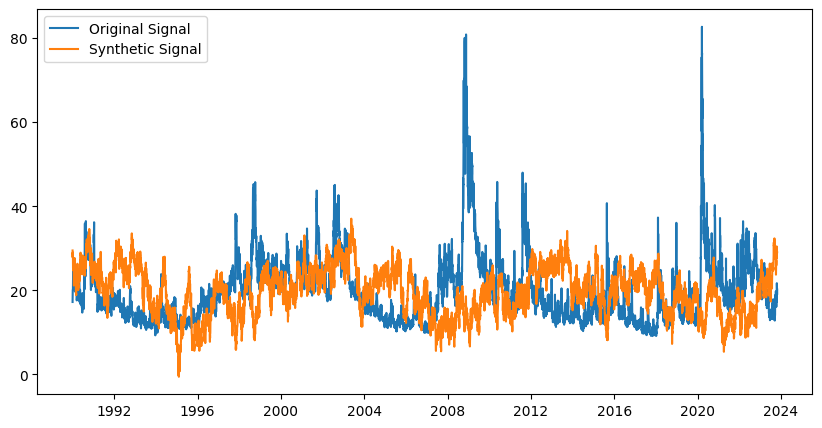

In [168]:

def generate_synthetic_signal(original_signal):
    # Step 1: Compute the FFT of the original signal
    signal_fft = np.fft.fft(original_signal)
    
    # Step 2: Randomize the phase
    random_phases = np.exp(1j * (np.angle(signal_fft) + 2 * np.pi * np.random.rand(*signal_fft.shape)))
    synthetic_spectrum = np.abs(signal_fft) * random_phases
    
    # Step 3: Compute the inverse FFT
    synthetic_signal = np.fft.ifft(synthetic_spectrum).real
    
    return synthetic_signal

# Generate a sample signal for demonstration
# time = np.arange(0, 10, 0.01)
time = vix_df['date'].values
# original_signal = np.sin(time) + 0.5 * np.sin(5 * time)  # This is just a sample signal
original_signal = vix_df['VIX'].values

synthetic_signal = generate_synthetic_signal(original_signal)
# we shift up the synthetic signal to match the original signal
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, original_signal, label='Original Signal')
plt.plot(time, synthetic_signal, label='Synthetic Signal')
plt.legend()
plt.show()


Number of spikes in original signal: 203
Number of spikes in synthetic signal: 203
0    17.24
1    18.19
2    19.22
3    20.11
4    20.26
Name: VIX, dtype: float64


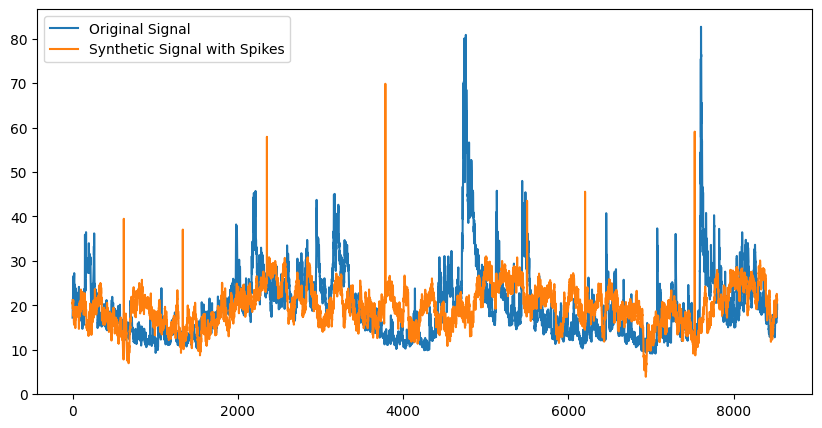

In [12]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude):
    # Generate random positions for spikes
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)
    
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.8, spike_magnitude], num_spikes)
    
    # Add spikes to the signal
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val
        
    return signal_with_spikes

threshold = 40  # Adjust based on original data
# diff_signal = np.diff(original_signal)
num_spikes_original = len(np.where(np.abs(vix_df['VIX'].values) > threshold)[0])
# we count how many times vix is above the threshold
num_spikes = len(np.where(np.abs(vix_df['VIX'].values) > threshold)[0])
print(f"Number of spikes in original signal: {num_spikes_original}")
print(f"Number of spikes in synthetic signal: {num_spikes}")
print(vix_df['VIX'].head())

# Add spikes to synthetic signal
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)

# Add spikes to synthetic signal
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 60)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()


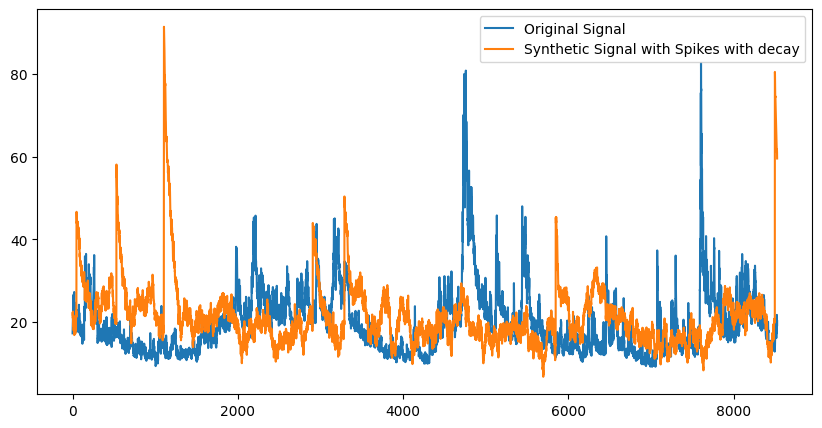

In [13]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude, decay_rate=0.985):
    # Generate random positions for spikes
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)
  
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.8, spike_magnitude, spike_magnitude*1.2], num_spikes)
    
    # Add spikes to the signal
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val
        # Apply decay to subsequent points
        decay_val = val
        for i in range(1, 175):  # 50 is an arbitrary number; adjust for how long you want the decay
            if pos+i < len(signal):
                decay_val *= decay_rate
                signal_with_spikes[pos+i] += decay_val
            else:
                break
                
    return signal_with_spikes

synthetic_signal = generate_synthetic_signal(original_signal)*0.8
# we shift up the synthetic signal to match the original signal
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())


synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 60)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes with decay')
plt.legend()
plt.show()


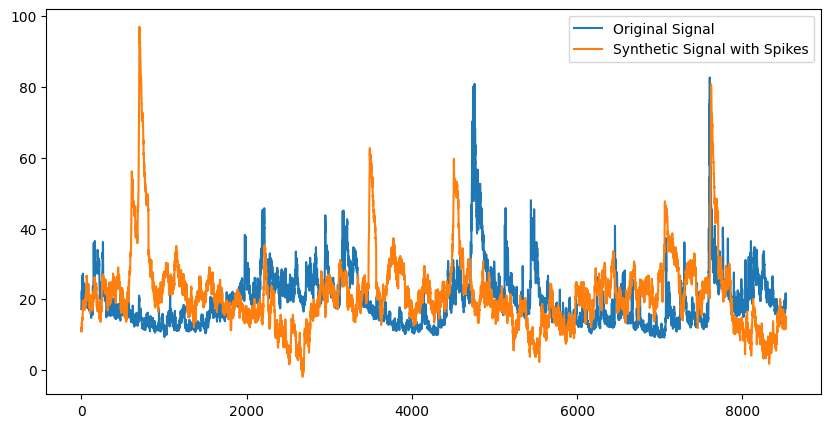

In [14]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude, in_decay_rate=0.9, out_decay_rate=0.985):
    # Generate random positions for spikes
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)
  
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.8, spike_magnitude, spike_magnitude*1.2], num_spikes)
    
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val

        decay_val = val
        decay_length = np.random.randint(75, 175)  # Varying decay length

        # Decay to the right
        for i in range(1, int(decay_length)):  
            if pos+i < len(signal):
                decay_val *= out_decay_rate
                signal_with_spikes[pos+i] += decay_val
            else:
                break

        # Decay to the left (before the spike)
        decay_val = val
        for i in range(1, int(decay_length*0.2)):  
            if pos-i >= 0:
                decay_val *= in_decay_rate
                signal_with_spikes[pos-i] += decay_val
            else:
                break
                
    return signal_with_spikes

synthetic_signal = generate_synthetic_signal(original_signal)
# we shift up the synthetic signal to match the original signal
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())

synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 55)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()


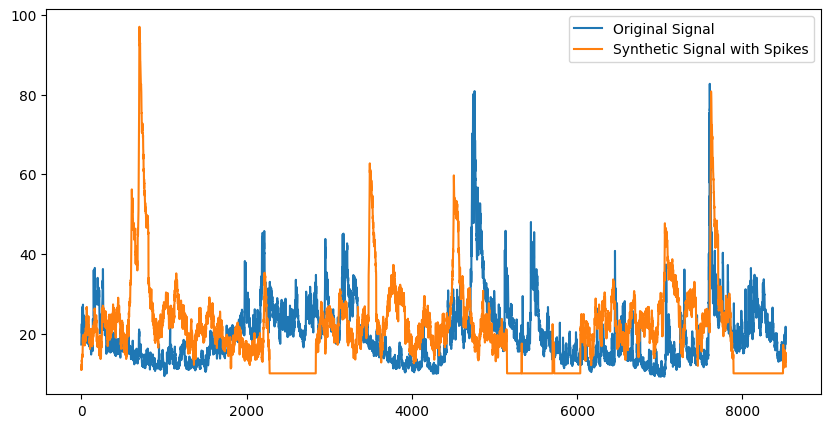

In [15]:
def apply_floor_with_blending(signal, floor_value=10, decay_rate=0.985):
    blended_signal = signal.copy()

    below_floor = np.where(blended_signal < floor_value)[0]
    
    for idx in below_floor:
        blended_signal[idx] = floor_value
        
        # Apply decay before (to the left of the floor)
        decay_val = floor_value - signal[idx]
        for i in range(1, 75):  # 75 is arbitrary, adjust based on desired decay length
            if idx-i >= 0:
                decay_val *= decay_rate
                blended_signal[idx-i] += min(decay_val, floor_value - blended_signal[idx-i])
            else:
                break
                
        # Apply decay after (to the right of the floor)
        decay_val = floor_value - signal[idx]
        for i in range(1, 75):  
            if idx+i < len(signal):
                decay_val *= decay_rate
                blended_signal[idx+i] += min(decay_val, floor_value - blended_signal[idx+i])
            else:
                break

    return blended_signal
blended_signal = apply_floor_with_blending(synthetic_signal_with_spikes)
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(blended_signal, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()

1046


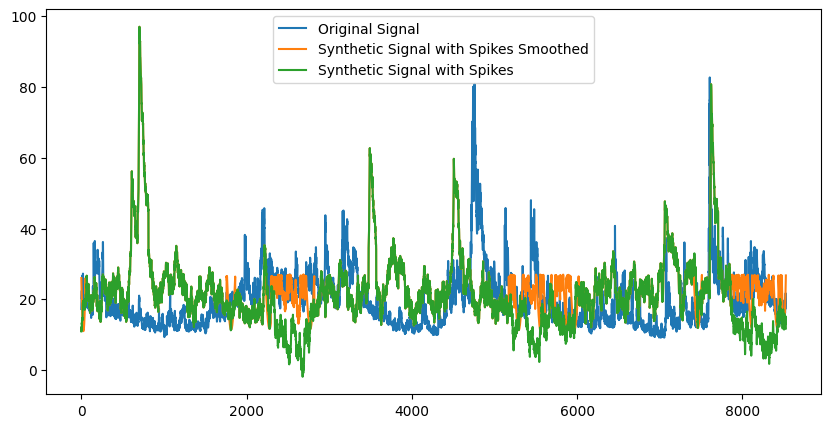

In [16]:
def smooth_bottoms(signal, threshold=12, width=100):
    smoothed_signal = signal.copy()
    sharp_bottoms = np.where(signal < threshold)[0]
    print(len(sharp_bottoms))

    # For each detected point, smoothen the region around it
    for idx in sharp_bottoms:
        # Create a U-shape using a quadratic function
        left = max(0, idx - width // 2)
        right = min(len(signal), idx + width // 2)
        x = np.linspace(-width // 2, width // 2, right - left)
        y = 0.006 * x**2 + signal[idx] #+ #x * 0.005 * signal[idx]

        # Update the signal with the U-shape
        smoothed_signal[left:right] = y

    return smoothed_signal
synthetic_signal_smoothed = smooth_bottoms(synthetic_signal_with_spikes)
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_smoothed, label='Synthetic Signal with Spikes Smoothed')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()

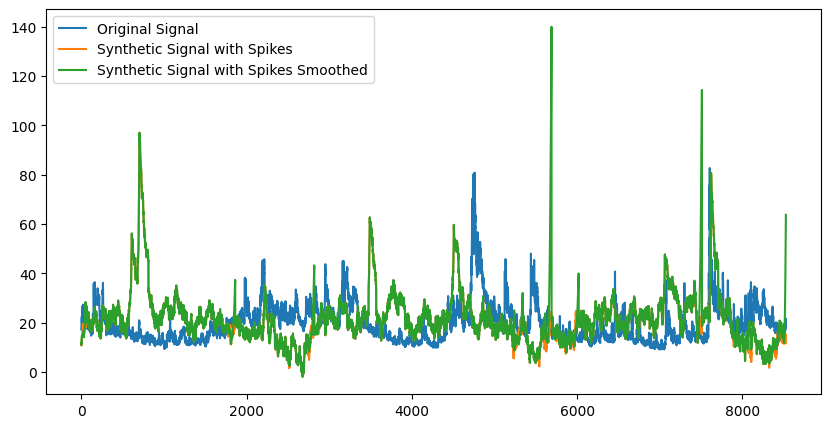

In [17]:
def smooth_bottoms2(signal, threshold=12, width=100):
    smoothed_signal = signal.copy()
    sharp_bottoms = np.where(signal < threshold)[0]

    # For each detected point, smoothen the region around it
    for idx in sharp_bottoms:
        # The curvature is inversely proportional to the difference
        # between the detected value and the threshold. 
        # The larger the difference, the smaller the curvature.
        curvature = 0.002 + 0.005 / (threshold - signal[idx] + 0.005)
        
        # Create a U-shape using a quadratic function
        left = max(0, idx - width // 2)
        right = min(len(signal), idx + width // 2)
        x = np.linspace(-width // 2, width // 2, right - left)
        y = curvature * x**2 + signal[idx]

        # Blend the generated U shape with the original signal
        alpha = np.linspace(0, 1, len(y))
        smoothed_signal[left:right] = alpha * y + (1 - alpha) * signal[left:right]

    return smoothed_signal

synthetic_signal_smoothed = smooth_bottoms2(synthetic_signal_with_spikes)
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.plot(synthetic_signal_smoothed, label='Synthetic Signal with Spikes Smoothed')

plt.legend()
plt.show()


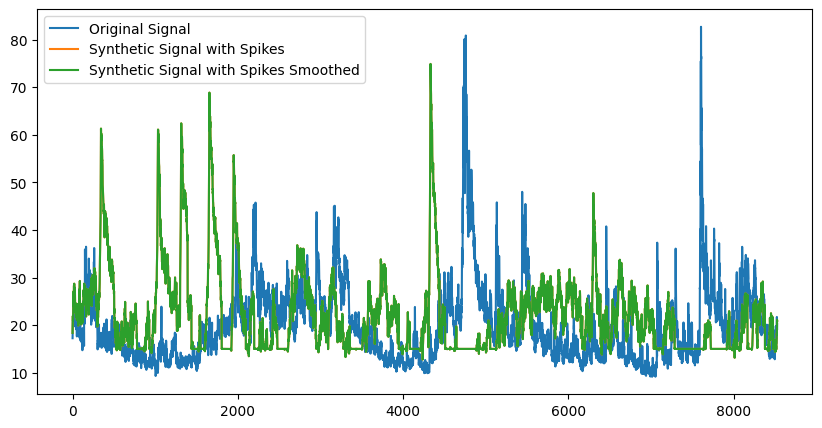

In [18]:
def smooth_bottoms_by_derivative(signal, threshold=10, blend_width=100):
    # Calculate the first derivative
    derivative = np.diff(signal)
    # Detect points where there's a change in sign, indicating a peak
    peaks = np.where(np.diff(np.sign(derivative)) > 0)[0]

    # For each detected peak, check if it's below the threshold
    for idx in peaks:
        if signal[idx] < threshold:
            signal[idx] = threshold
            # Blend on both sides of the peak
            left = max(0, idx - blend_width // 2)
            right = min(len(signal), idx + blend_width // 2)
            # Generate linear blending factors
            blend_factors = np.linspace(0, 1, right - left)
            # Blend using a weighted average of the signal and the threshold
            signal[left:right] = blend_factors * signal[left:right] + (1 - blend_factors) * threshold
            
    return signal


synthetic_signal = generate_synthetic_signal(original_signal)
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 55)
synthetic_signal_smoothed = smooth_bottoms_by_derivative(synthetic_signal_with_spikes, 15, 50)

plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.plot(synthetic_signal_smoothed, label='Synthetic Signal with Spikes Smoothed')

plt.legend()
plt.show()


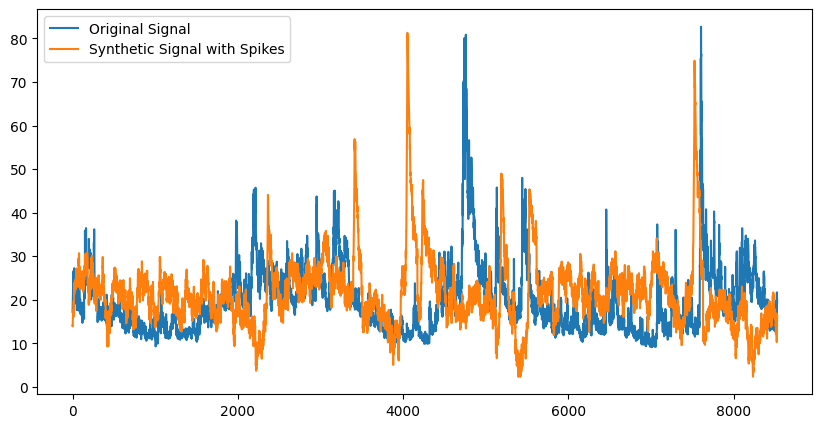

In [128]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude, in_decay_rate=0.9, out_decay_rate=0.985):
    # Generate random positions for spikes
    num_spikes_delta = num_spikes - int(num_spikes)
    num_spikes = int(num_spikes)
    if np.random.rand() < num_spikes_delta:
        num_spikes += 1
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)

  
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.95, spike_magnitude, spike_magnitude*1.05], num_spikes)
    
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val

        decay_val = val
        decay_length = np.random.randint(75, 175)  # Varying decay length

        # Decay to the right
        for i in range(1, int(decay_length)):  
            if pos+i < len(signal):
                decay_val *= out_decay_rate
                signal_with_spikes[pos+i] += decay_val
            else:
                break

        # Decay to the left (before the spike)
        decay_val = val
        for i in range(1, int(decay_length*0.2)):  
            if pos-i >= 0:
                decay_val *= in_decay_rate
                signal_with_spikes[pos-i] += decay_val
            else:
                break
                
    return signal_with_spikes

synthetic_signal = generate_synthetic_signal(original_signal)
# we shift up the synthetic signal to match the original signal
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())

synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 55)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()


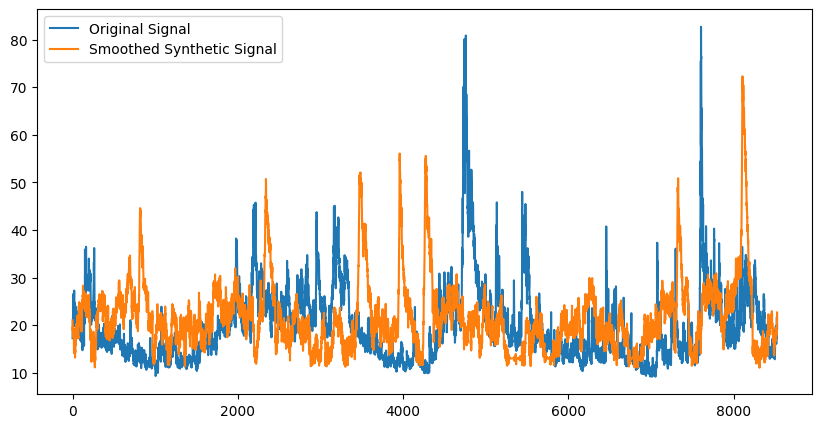

In [20]:
def smooth_bottoms_by_value(signal):
    smoothed_signal = signal.copy()
    
    # 1. Detect regions where the value goes below 11.
    below_11_indices = np.where(signal < 11)[0]

    # If there are no regions below 11, return the original signal
    if len(below_11_indices) == 0:
        return signal

    for idx in below_11_indices:
        # 2. For each detected region:
        
        # Find the left boundary where the value first reaches or exceeds 13.
        left_idx = idx
        while left_idx > 0 and smoothed_signal[left_idx] < 13:
            left_idx -= 1

        # Find the right boundary where the value first reaches or exceeds 13.
        right_idx = idx
        while right_idx < len(smoothed_signal) - 1 and smoothed_signal[right_idx] < 13:
            right_idx += 1
        
        # 3. Adjust values within the region based on the range they fall into.
        for i in range(left_idx, right_idx + 1):
            if smoothed_signal[i] < 10:
                smoothed_signal[i] = 10
            elif 10 <= smoothed_signal[i] < 11:
                smoothed_signal[i] += 1
            elif 11 <= smoothed_signal[i] < 12:
                smoothed_signal[i] += 0.75
            elif 12 <= smoothed_signal[i] < 13:
                smoothed_signal[i] += 0.5

    return smoothed_signal

# Apply the smoothing function
synthetic_signal = generate_synthetic_signal(original_signal)
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 55)
synthetic_signal_smoothed = smooth_bottoms_by_value(synthetic_signal_with_spikes)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_smoothed, label='Smoothed Synthetic Signal')
plt.legend()
plt.show()


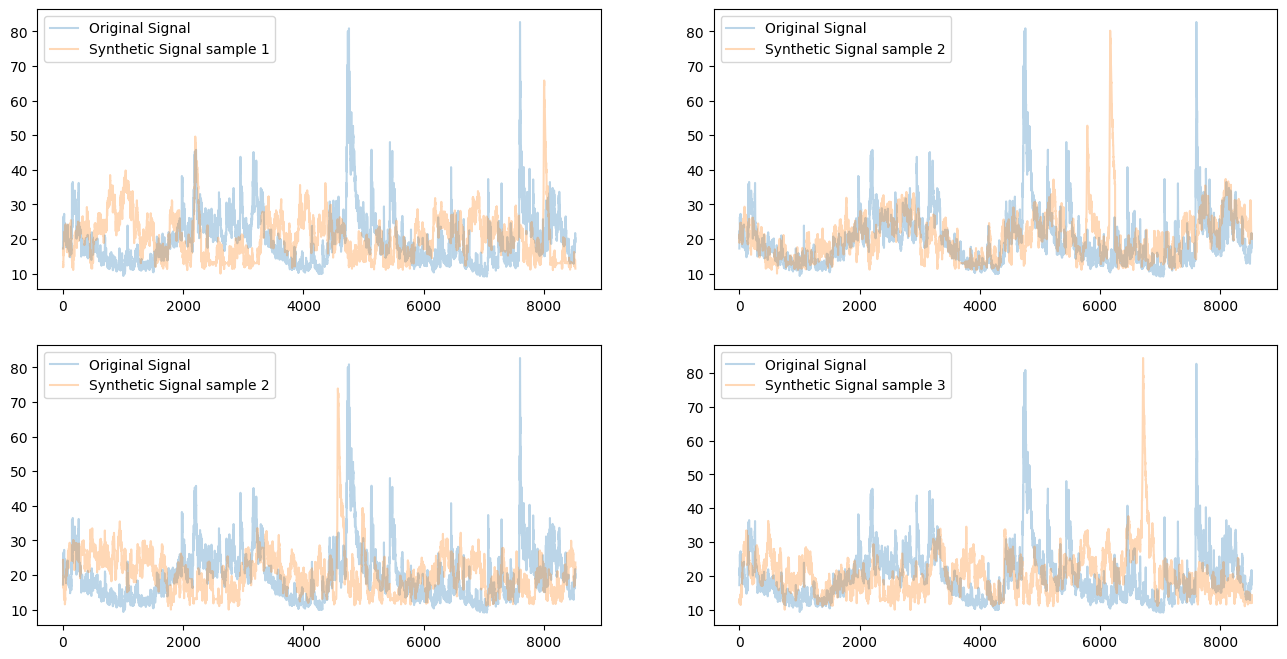

In [129]:

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
# Generate a random synthetic signal for each subplot
for i in range(2):
    for j in range(2):
        synthetic_signal = generate_synthetic_signal(original_signal)
        synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
        synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 1, 30)
        synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 1, 55)
        synthetic_signal_smoothed = smooth_bottoms_by_value(synthetic_signal_with_spikes)
        axs[i, j].plot(original_signal, alpha=0.3,label='Original Signal')
        axs[i, j].plot(synthetic_signal_smoothed, alpha=0.3, label=f'Synthetic Signal sample {i+j+1}')
        axs[i, j].legend()

# Show the plot
# fig.title('Synthetic vs Original VIX Signals')
plt.show()


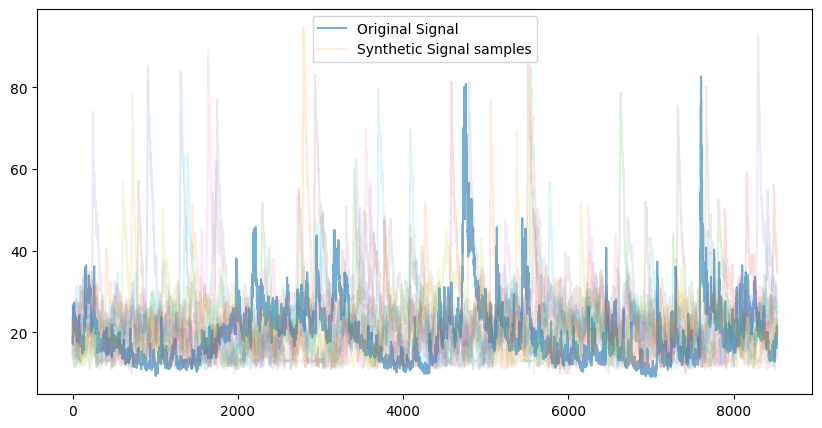

In [130]:

# Create a figure with four subplots
# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal', alpha=0.6)


# Generate a random synthetic signal for each subplot
for i in range(10):
    synthetic_signal = generate_synthetic_signal(original_signal)
    synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
    synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
    synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 60)
    synthetic_signal_smoothed = smooth_bottoms_by_value(synthetic_signal_with_spikes)
    plt.plot(synthetic_signal_smoothed, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
    plt.legend()

# Show the plot
# fig.title('Synthetic vs Original VIX Signals')
plt.show()

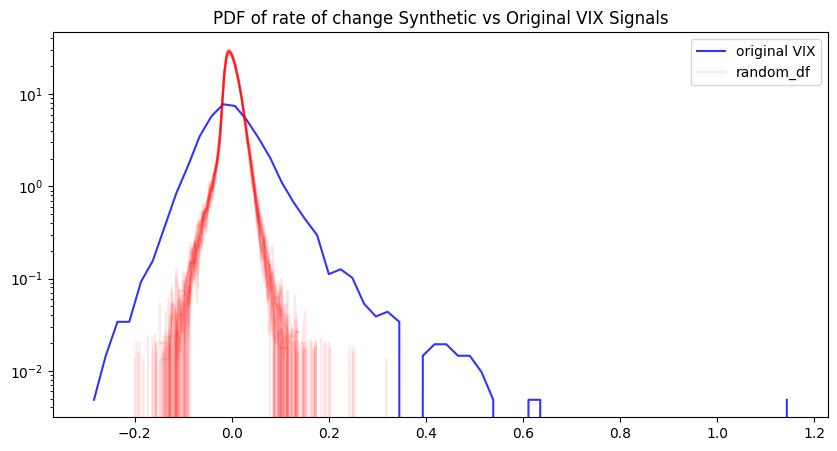

In [131]:

# Create a figure with four subplots
# Plot
plt.figure(figsize=(10, 5))
# plt.plot(original_signal, label='Original Signal', alpha=0.6)
original_signal_df = pd.DataFrame(original_signal)

n, bins, patches = plt.hist(original_signal_df.pct_change(), bins=60, alpha=0, color='red', density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
plt.plot(bin_centers, n, color='blue', alpha=0.8,  label='original VIX')

# Generate a random synthetic signal for each subplot
for i in range(20):
    synthetic_signal = generate_synthetic_signal(original_signal)
    synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
    synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 500, 30)
    synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 300, 60)
    synthetic_signal_smoothed = smooth_bottoms_by_value(synthetic_signal_with_spikes)
    synthetic_signal_smoothed_df = pd.DataFrame(synthetic_signal_smoothed)

    n, bins, patches = plt.hist(synthetic_signal_smoothed_df.pct_change(), bins=60, alpha=0, color='red', density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)
    
    # plt.plot(synthetic_signal_smoothed, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
    plt.legend()

# Show the plot
plt.title('PDF of rate of change Synthetic vs Original VIX Signals')
plt.yscale('log')
plt.show()

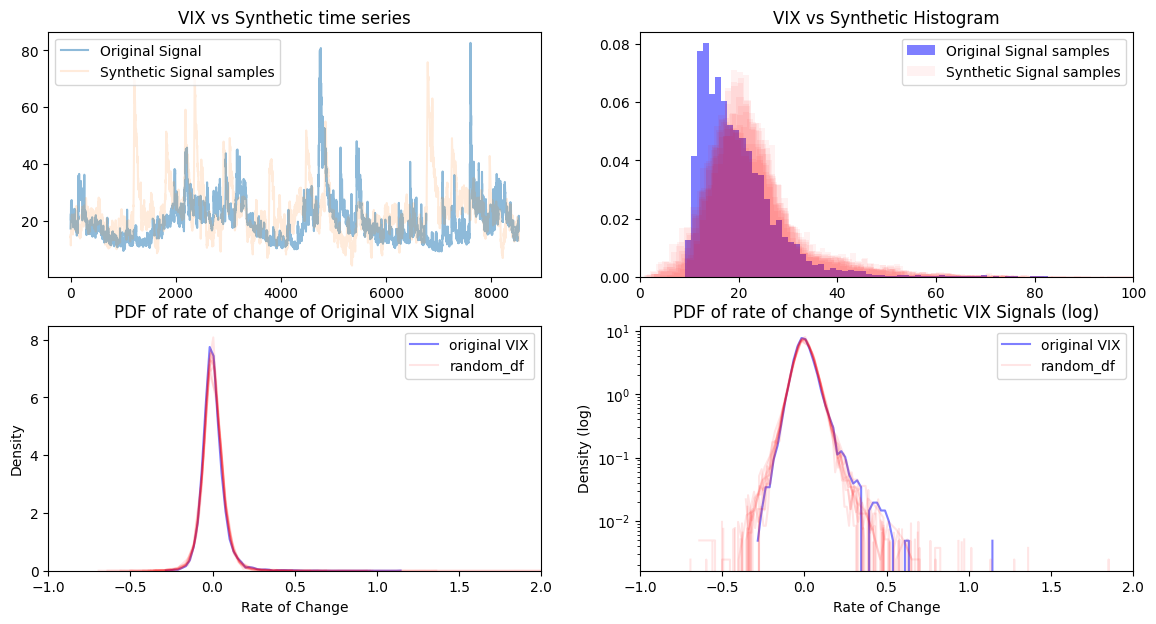

In [209]:

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

# Plot the original 4 plots
original_signal_df = pd.DataFrame(original_signal)
n, bins, patches = axs[0,1].hist(original_signal_df, bins=60, alpha=0, color='red', density=True)
n, bins, patches = axs[1,0].hist(original_signal_df.pct_change(), bins=60, alpha=0, color='red', density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
axs[1,1].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')
axs[1,0].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')

axs[0,0].plot(original_signal, label='Original Signal', alpha=0.5)
# axs[1,1].plot(original_signal, label='Original Signal', alpha=0.8)
n, bins, patches = axs[0,1].hist(original_signal, bins=60, alpha=0.5, color='blue', density=True, label=f'Original Signal samples' )

  

# Plot the second subplot with log y scale
for i in range(10):
    synthetic_signal = generate_synthetic_signal(original_signal)
    synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
    # synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 1000, 10)
    # synthetic_signal = add_spikes_to_signal(synthetic_signal, 100, 15)
    synthetic_signal = add_spikes_to_signal(synthetic_signal, 11, 30)
    # synthetic_signal = add_spikes_to_signal(synthetic_signal, 10, 45)
    synthetic_signal = add_spikes_to_signal(synthetic_signal, 2.5, 55)
    # synthetic_signal_smoothed = smooth_bottoms_by_value(synthetic_signal_with_spikes)
    synthetic_signal = pd.DataFrame(synthetic_signal)

    n, bins, patches = axs[1,0].hist(synthetic_signal.pct_change(), bins=60, alpha=0, color='red', density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    axs[1,0].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)
    axs[1,1].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

    if i == 0:
        axs[0,0].plot(synthetic_signal, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
        axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True, label=f'Synthetic Signal samples' if i == 0 else None)

    else:
        axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True)

    axs[0,0].legend()
    axs[0,1].legend()
    axs[1,0].legend()
    axs[1,1].legend()

# Set the titles and y scales of the subplots
axs[1,0].set_title('PDF of rate of change of Original VIX Signal')
axs[1,1].set_title('PDF of rate of change of Synthetic VIX Signals (log)')
axs[1,1].set_ylabel('Density (log)')
axs[1,0].set_ylabel('Density')
axs[1,0].set_xlabel('Rate of Change')
axs[1,1].set_xlabel('Rate of Change')
axs[1,1].set_yscale('log')
axs[0,0].set_title('VIX vs Synthetic time series')
axs[0,1].set_title('VIX vs Synthetic Histogram')
axs[1,0].set_xlim(-1, 2)
axs[1,1].set_xlim(-1, 2)
axs[0,1].set_xlim(0,100)

# Show the plot
plt.show()

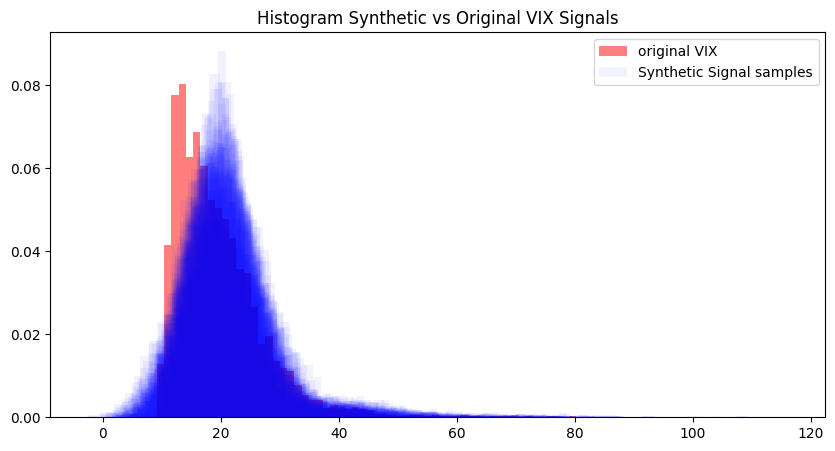

In [200]:

# Create a figure with four subplots
# Plot
plt.figure(figsize=(10, 5))
# plt.plot(original_signal, label='Original Signal', alpha=0.6)
original_signal_df = pd.DataFrame(original_signal)

n, bins, patches = plt.hist(original_signal_df, bins=60, alpha=0.5, color='red', density=True, label='original VIX')


# Generate a random synthetic signal for each subplot
for i in range(40):
    synthetic_signal = generate_synthetic_signal(original_signal)
    synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
    synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 6, 30)
    synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 1.5, 60)
    # synthetic_signal_smoothed = smooth_bottoms_by_value(synthetic_signal_with_spikes)-1.5
    # synthetic_signal_smoothed_df = pd.DataFrame(synthetic_signal_with_spikes)

    n, bins, patches = plt.hist(synthetic_signal_with_spikes, bins=60, alpha=0.05, color='blue', density=True, label=f'Synthetic Signal samples' if i == 0 else None)
    
    # plt.plot(synthetic_signal_smoothed, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
    plt.legend()

# Show the plot
plt.title('Histogram Synthetic vs Original VIX Signals')
# plt.yscale('log')
plt.show()

[]

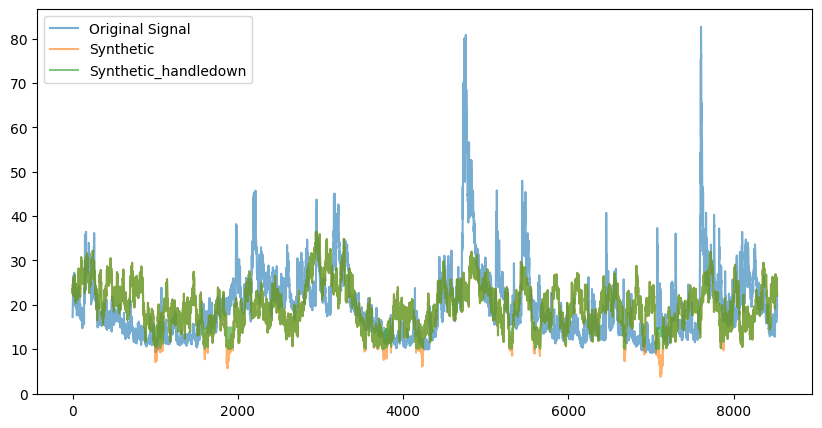

In [322]:
def handle_floor(synthetic_signal):
    # if the mean of 10 samples is below 10, we calculate the difference of each sample to 10, and add twice the difference to the sample
    # we detect the index positions where the rolling mean is below 11
    synthetic_signal_df = pd.DataFrame(synthetic_signal)
    synthetic_signal_df['rolling_mean'] = synthetic_signal_df.rolling(10).mean()
    # we detect the index positions where rolling mean is below 11
    below_11_indices = np.where(synthetic_signal_df['rolling_mean'] < 11)[0]
    # for each index position, we add twice the difference between the rolling mean and 10 to the sample
    for idx in below_11_indices:
        synthetic_signal[idx] += 3*(10 - synthetic_signal_df['rolling_mean'][idx])
    
    return synthetic_signal

def handle_down_candle(synthetic_signal):
    # we calculate the pct change for the signal at each step
    synthetic_signal_df = pd.DataFrame(synthetic_signal)

    synthetic_signal_df['pct_change'] = synthetic_signal_df.pct_change()
    # print(synthetic_signal_df.head())
    # if change is below -35% we flip the sign to opposite
    # we recalculate the signal from the pct change, by doing a cumprod
    # synthetic_signal_df['pct_change'][0] = synthetic_signal[0]
    # synthetic_signal_df['signal'] = synthetic_signal_df['pct_change'].add(1).cumprod()
    for i, row in synthetic_signal_df.iterrows():
        if row[0] < 10:
            synthetic_signal_df[0][i] = 13 + np.random.rand()*2

    return synthetic_signal_df[0].values

synthetic_signal = generate_synthetic_signal(original_signal)
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal', alpha=0.6)
plt.plot(synthetic_signal, label='Synthetic', alpha=0.6)
plt.plot(handle_down_candle(synthetic_signal), label='Synthetic_handledown', alpha=0.6)
plt.legend()
plt.plot()


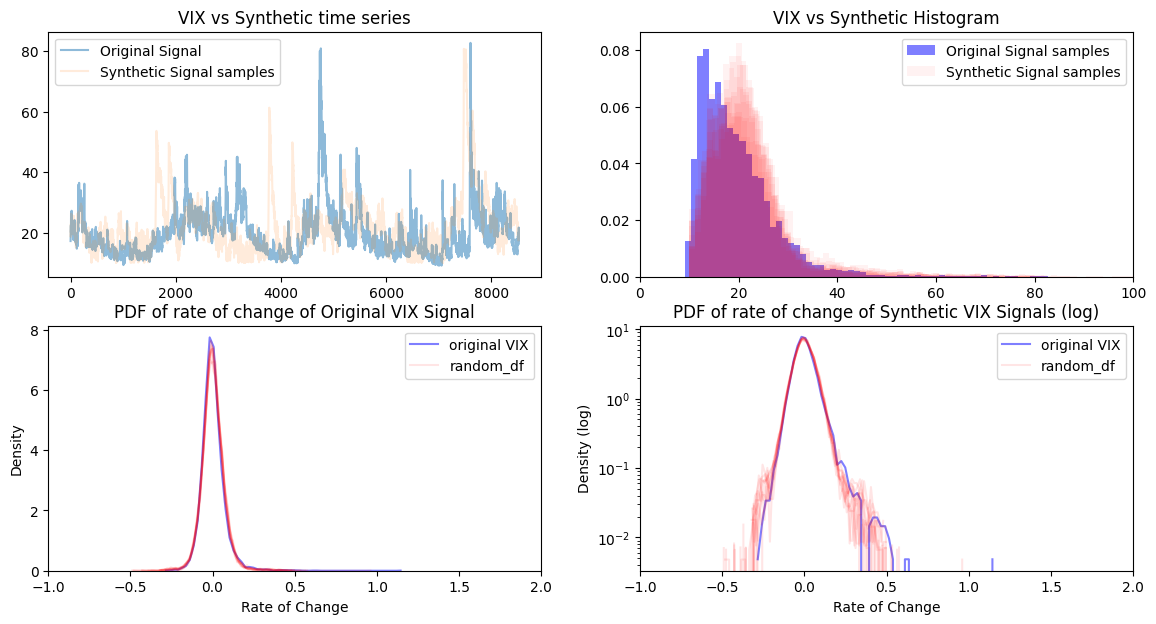

In [323]:

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

# Plot the original 4 plots
original_signal_df = pd.DataFrame(original_signal)
n, bins, patches = axs[0,1].hist(original_signal_df, bins=60, alpha=0, color='red', density=True)
n, bins, patches = axs[1,0].hist(original_signal_df.pct_change(), bins=60, alpha=0, color='red', density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
axs[1,1].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')
axs[1,0].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')

axs[0,0].plot(original_signal, label='Original Signal', alpha=0.5)
# axs[1,1].plot(original_signal, label='Original Signal', alpha=0.8)
n, bins, patches = axs[0,1].hist(original_signal, bins=60, alpha=0.5, color='blue', density=True, label=f'Original Signal samples' )

  

# Plot the second subplot with log y scale
for i in range(10):
    synthetic_signal = generate_synthetic_signal(original_signal)
    synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
    synthetic_signal = add_spikes_to_signal(synthetic_signal, 5, 30)
    synthetic_signal = add_spikes_to_signal(synthetic_signal, 2.5, 55)
    synthetic_signal = handle_floor(synthetic_signal)
    synthetic_signal = handle_down_candle(synthetic_signal)
    synthetic_signal = pd.DataFrame(synthetic_signal)

    n, bins, patches = axs[1,0].hist(synthetic_signal.pct_change(), bins=60, alpha=0, color='red', density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    axs[1,0].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)
    axs[1,1].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

    if i == 0:
        axs[0,0].plot(synthetic_signal, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
        axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True, label=f'Synthetic Signal samples' if i == 0 else None)

    else:
        axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True)

    axs[0,0].legend()
    axs[0,1].legend()
    axs[1,0].legend()
    axs[1,1].legend()

# Set the titles and y scales of the subplots
axs[1,0].set_title('PDF of rate of change of Original VIX Signal')
axs[1,1].set_title('PDF of rate of change of Synthetic VIX Signals (log)')
axs[1,1].set_ylabel('Density (log)')
axs[1,0].set_ylabel('Density')
axs[1,0].set_xlabel('Rate of Change')
axs[1,1].set_xlabel('Rate of Change')
axs[1,1].set_yscale('log')
axs[0,0].set_title('VIX vs Synthetic time series')
axs[0,1].set_title('VIX vs Synthetic Histogram')
axs[1,0].set_xlim(-1, 2)
axs[1,1].set_xlim(-1, 2)
axs[0,1].set_xlim(0,100)

# Show the plot
plt.show()

In [401]:
# Assuming synthetic_signal is a NumPy array or a Pandas Series
synthetic_signal = generate_synthetic_signal(original_signal)  # Your existing synthetic signal generation

def apply_skew(synthetic_signal, skew_factor=1.5):
    # power = 1.4  # Adjust this value as needed
    synthetic_signal_transformed = synthetic_signal ** skew_factor
    # Optional: Re-normalization to match original data's mean and standard deviation
    synthetic_signal_transformed = (synthetic_signal_transformed - synthetic_signal_transformed.mean()) / synthetic_signal_transformed.std()
    synthetic_signal_transformed = synthetic_signal_transformed * original_signal.std() + original_signal.mean()
    return synthetic_signal_transformed


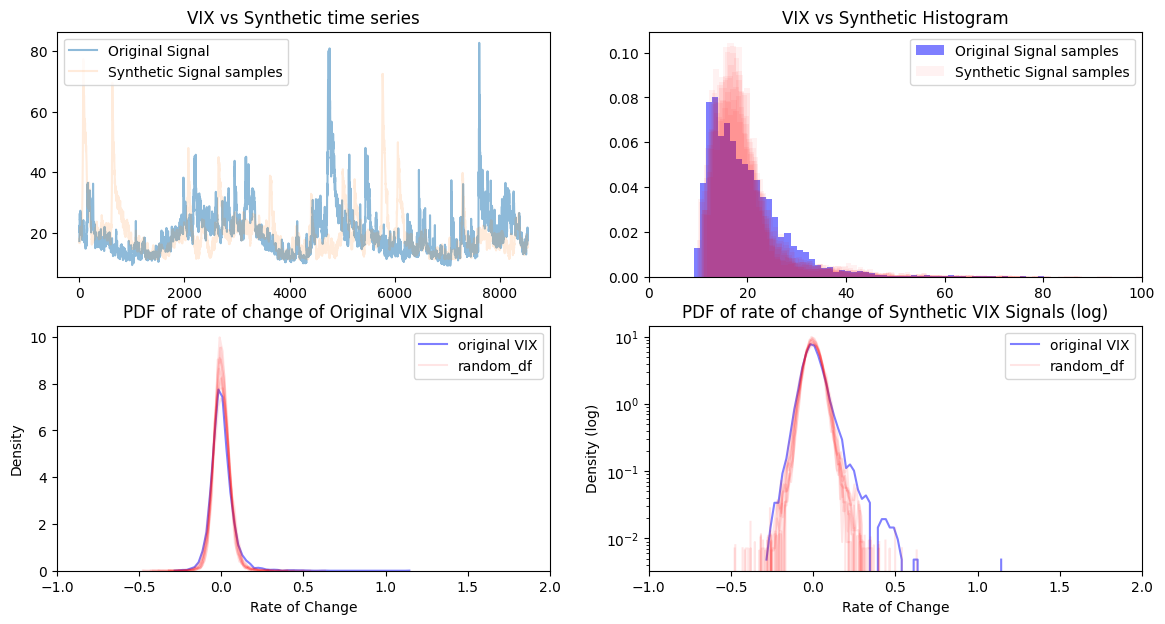

In [352]:

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

# Plot the original 4 plots
original_signal_df = pd.DataFrame(original_signal)
n, bins, patches = axs[0,1].hist(original_signal_df, bins=60, alpha=0, color='red', density=True)
n, bins, patches = axs[1,0].hist(original_signal_df.pct_change(), bins=60, alpha=0, color='red', density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
axs[1,1].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')
axs[1,0].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')

axs[0,0].plot(original_signal, label='Original Signal', alpha=0.5)
# axs[1,1].plot(original_signal, label='Original Signal', alpha=0.8)
n, bins, patches = axs[0,1].hist(original_signal, bins=60, alpha=0.5, color='blue', density=True, label=f'Original Signal samples' )

  

# Plot the second subplot with log y scale
for i in range(10):
    synthetic_signal = generate_synthetic_signal(original_signal)
    synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
    synthetic_signal = add_spikes_to_signal(synthetic_signal, 8, 30)
    synthetic_signal = add_spikes_to_signal(synthetic_signal, 2.5, 55)
    synthetic_signal = handle_floor(synthetic_signal)
    synthetic_signal = handle_down_candle(synthetic_signal)
    synthetic_signal = apply_skew(synthetic_signal)
    synthetic_signal = pd.DataFrame(synthetic_signal)

    n, bins, patches = axs[1,0].hist(synthetic_signal.pct_change(), bins=60, alpha=0, color='red', density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    axs[1,0].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)
    axs[1,1].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

    if i == 0:
        axs[0,0].plot(synthetic_signal, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
        axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True, label=f'Synthetic Signal samples' if i == 0 else None)

    else:
        axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True)

    axs[0,0].legend()
    axs[0,1].legend()
    axs[1,0].legend()
    axs[1,1].legend()

# Set the titles and y scales of the subplots
axs[1,0].set_title('PDF of rate of change of Original VIX Signal')
axs[1,1].set_title('PDF of rate of change of Synthetic VIX Signals (log)')
axs[1,1].set_ylabel('Density (log)')
axs[1,0].set_ylabel('Density')
axs[1,0].set_xlabel('Rate of Change')
axs[1,1].set_xlabel('Rate of Change')
axs[1,1].set_yscale('log')
axs[0,0].set_title('VIX vs Synthetic time series')
axs[0,1].set_title('VIX vs Synthetic Histogram')
axs[1,0].set_xlim(-1, 2)
axs[1,1].set_xlim(-1, 2)
axs[0,1].set_xlim(0,100)

# Show the plot
plt.show()

In [521]:
def swap_20_30(synthetic_signal, random_factor=0.1, decay_rate=0.5, decay_length_input=30, impact_factor=5):
    syn_df = pd.DataFrame(synthetic_signal)
    for i, row in syn_df.iterrows():
        if row[0] < 24 and row[0] > 17 and np.random.rand() < random_factor:
            syn_df[0][i] = 19 + np.random.rand()*impact_factor
            # include decay to the right
            decay_val = syn_df[0][i]
            decay_length = np.random.randint(decay_length_input/2, decay_length_input)
            for j in range(1, int(decay_length)):  
                if i+j < len(syn_df):
                    decay_val *= decay_rate
                    syn_df[0][i+j] += decay_val
                else:
                    break
            # include decay to the left
            decay_val = 19 + np.random.rand()*impact_factor
            decay_length = np.random.randint(decay_length_input/2, decay_length_input)
            for j in range(1, int(decay_length)):  
                if i-j >= 0:
                    decay_val *= decay_rate
                    syn_df[0][i-j] += decay_val
                else:
                    break
        elif row[0] < 20 and row[0] > 15 and np.random.rand() < random_factor*0.6:
            syn_df[0][i] = 16 - np.random.rand()*impact_factor/5
            # include decay to the right
            decay_val = syn_df[0][i]
            decay_length = np.random.randint(decay_length_input/2, decay_length_input)
            for j in range(1, int(decay_length)):  
                if i+j < len(syn_df):
                    decay_val *= decay_rate/2
                    syn_df[0][i+j] += decay_val
                else:
                    break
            # include decay to the left
            decay_val = 16 - np.random.rand()*impact_factor/5
            decay_length = np.random.randint(decay_length_input/2, decay_length_input)
            for j in range(1, int(decay_length)):  
                if i-j >= 0:
                    decay_val *= decay_rate/2
                    syn_df[0][i-j] += decay_val
                else:
                    break

    return syn_df[0].values



In [515]:
def test_generator(simulations=5, random_factor=0.1,skew_factor=1.4, decay_rate=0.5, decay_length_input=30, impact_factor=5):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 7))

    # Plot the original 4 plots
    original_signal_df = pd.DataFrame(original_signal)
    n, bins, patches = axs[0,1].hist(original_signal_df, bins=60, alpha=0, color='red', density=True)
    n, bins, patches = axs[1,0].hist(original_signal_df.pct_change(), bins=60, alpha=0, color='red', density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    axs[1,1].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')
    axs[1,0].plot(bin_centers, n, color='blue', alpha=0.5,  label='original VIX')

    axs[0,0].plot(original_signal, label='Original Signal', alpha=0.5)
    # axs[1,1].plot(original_signal, label='Original Signal', alpha=0.8)
    n, bins, patches = axs[0,1].hist(original_signal, bins=60, alpha=0.5, color='blue', density=True, label=f'Original Signal samples' )

    

    # Plot the second subplot with log y scale
    for i in range(simulations):
        synthetic_signal = generate_synthetic_signal(original_signal)
        synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
        synthetic_signal = add_spikes_to_signal(synthetic_signal, 15, 32)
        synthetic_signal = add_spikes_to_signal(synthetic_signal, 2, 60)
        synthetic_signal = handle_floor(synthetic_signal)
        synthetic_signal = handle_down_candle(synthetic_signal)
        synthetic_signal = apply_skew(synthetic_signal, skew_factor)
        synthetic_signal = swap_20_30(synthetic_signal, random_factor, decay_rate, decay_length_input, impact_factor)
        synthetic_signal = pd.DataFrame(synthetic_signal)

        n, bins, patches = axs[1,0].hist(synthetic_signal.pct_change(), bins=60, alpha=0, color='red', density=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        axs[1,0].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)
        axs[1,1].plot(bin_centers, n, color='red', alpha=0.1,  label='random_df' if i == 0 else None)

        if i == 0:
            axs[0,0].plot(synthetic_signal, alpha=0.15, label=f'Synthetic Signal samples' if i == 0 else None)
            axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True, label=f'Synthetic Signal samples' if i == 0 else None)

        else:
            axs[0,1].hist(synthetic_signal, bins=60, alpha=0.05, color='red', density=True)

        axs[0,0].legend()
        axs[0,1].legend()
        axs[1,0].legend()
        axs[1,1].legend()

    # Set the titles and y scales of the subplots
    axs[1,0].set_title('PDF of rate of change of Original VIX Signal')
    axs[1,1].set_title('PDF of rate of change of Synthetic VIX Signals (log)')
    axs[1,1].set_ylabel('Density (log)')
    axs[1,0].set_ylabel('Density')
    axs[1,0].set_xlabel('Rate of Change')
    axs[1,1].set_xlabel('Rate of Change')
    axs[1,1].set_yscale('log')
    axs[0,0].set_title('VIX vs Synthetic time series')
    axs[0,1].set_title('VIX vs Synthetic Histogram')
    axs[1,0].set_xlim(-1, 2)
    axs[1,1].set_xlim(-1, 2)
    axs[0,1].set_xlim(0,100)

    # Show the plot
    plt.show()

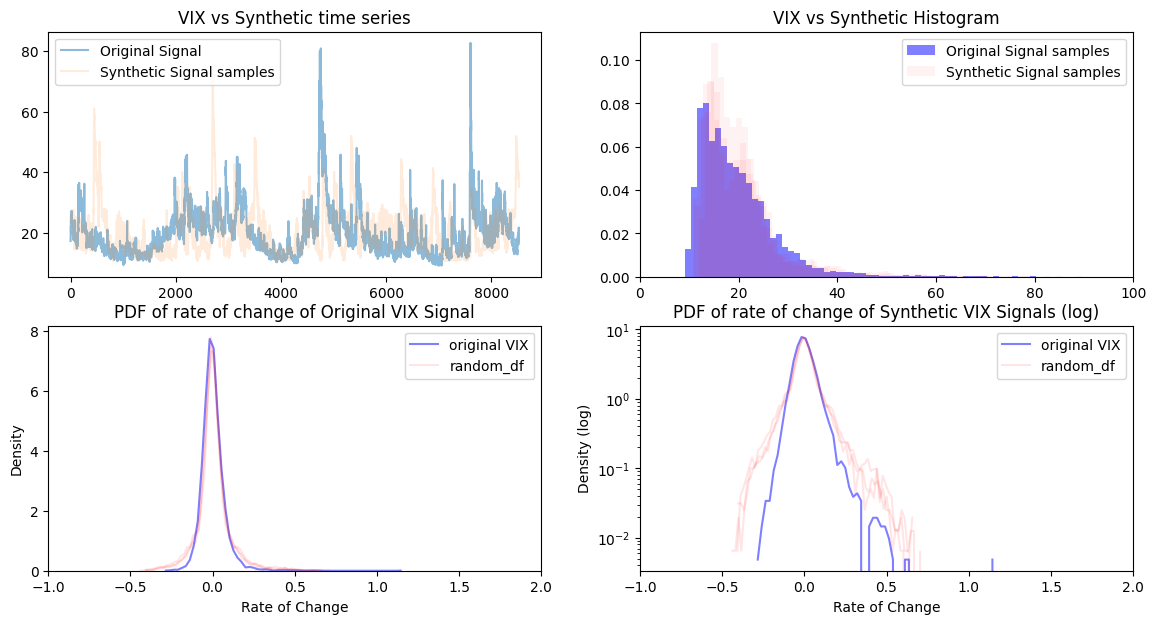

In [498]:
test_generator(simulations=3,random_factor=0.15, skew_factor=1.4, decay_rate=0.15, decay_length_input=30)

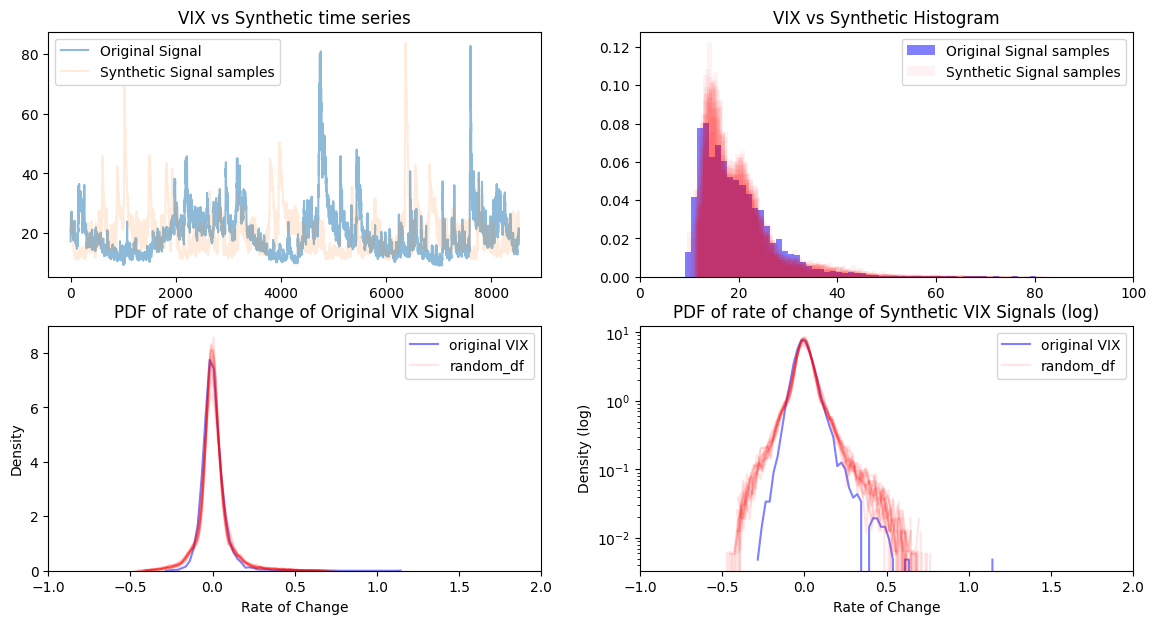

In [499]:
test_generator(simulations=15,random_factor=0.12, skew_factor=1.4, decay_rate=0.15, decay_length_input=30)

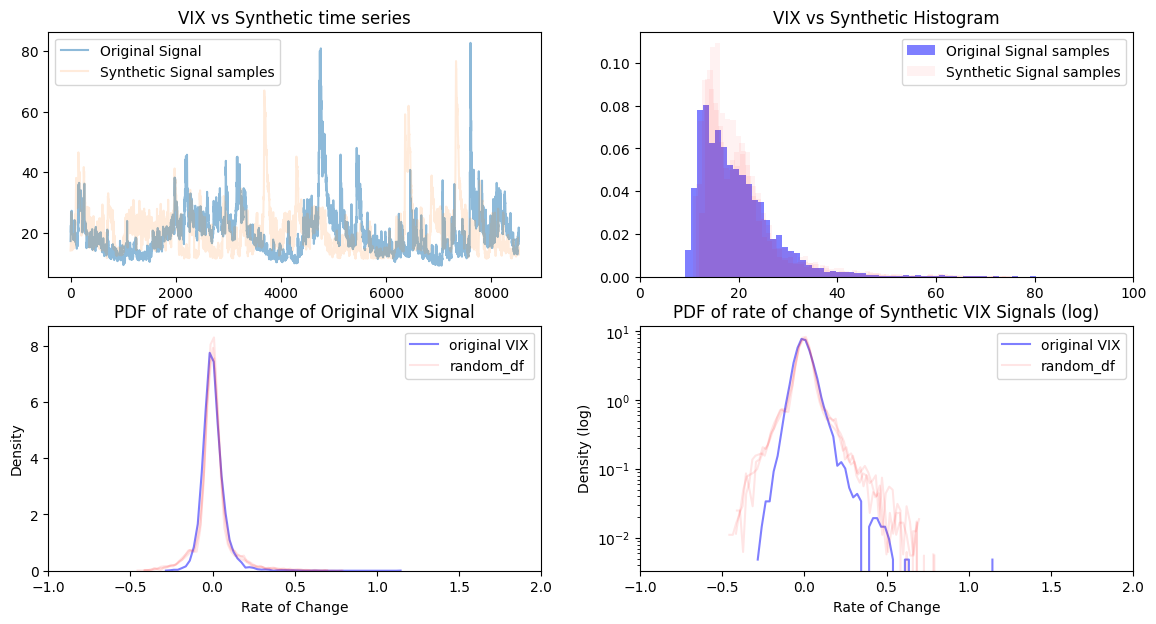

In [500]:
test_generator(simulations=3,random_factor=0.1, skew_factor=1.4, decay_rate=0.2, decay_length_input=30)

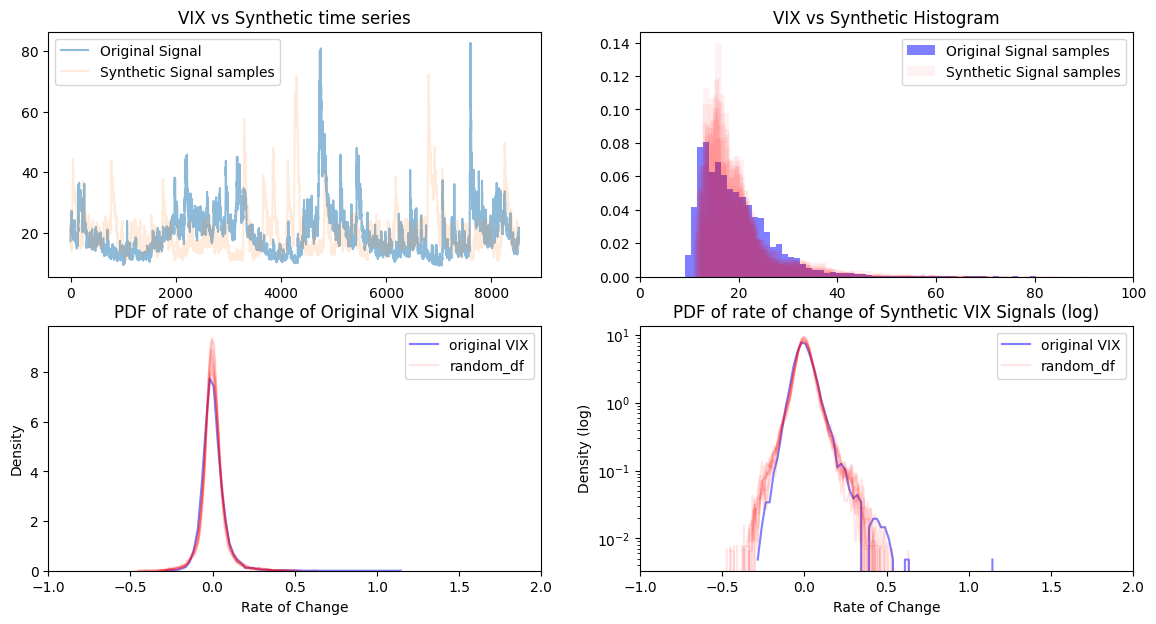

In [529]:
test_generator(simulations=10,random_factor=0.1, skew_factor=1.4, decay_rate=0.1, decay_length_input=60)

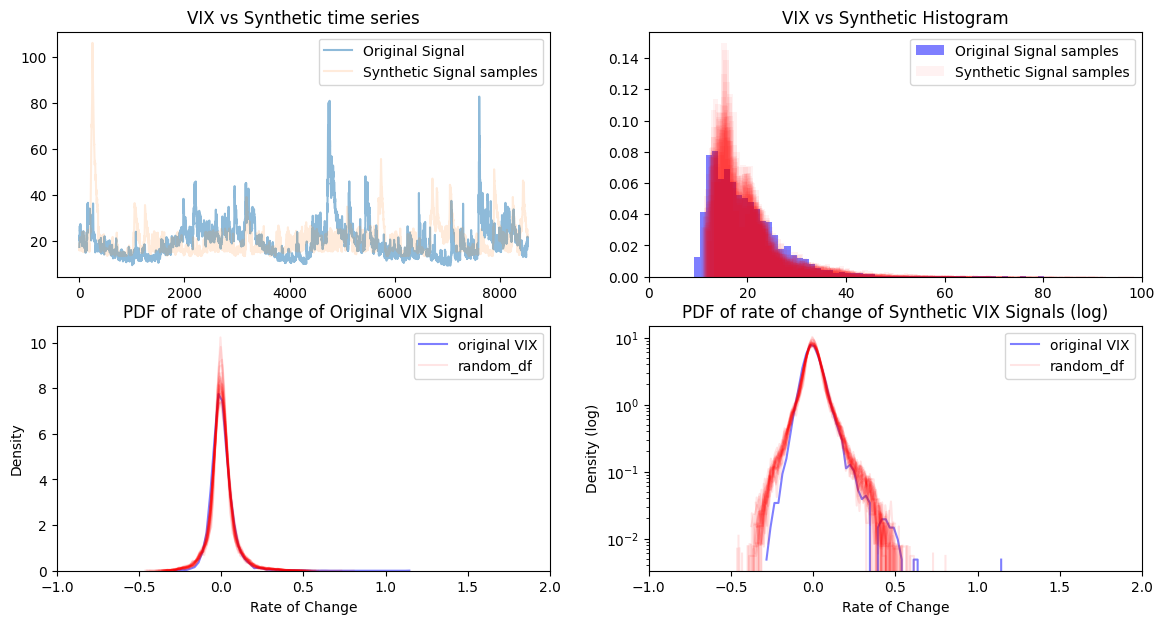

In [530]:
test_generator(simulations=25,random_factor=0.13, skew_factor=1.5, decay_rate=0.12, decay_length_input=90)

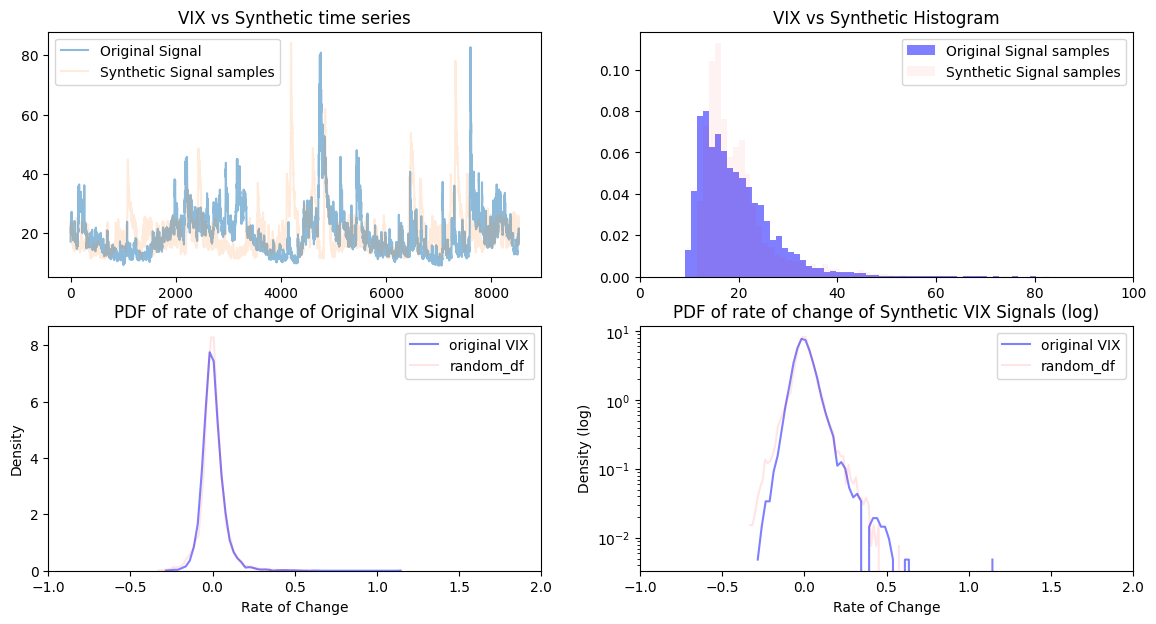

In [531]:
test_generator(simulations=1,random_factor=0.13, skew_factor=1.5, decay_rate=0.12, decay_length_input=90)

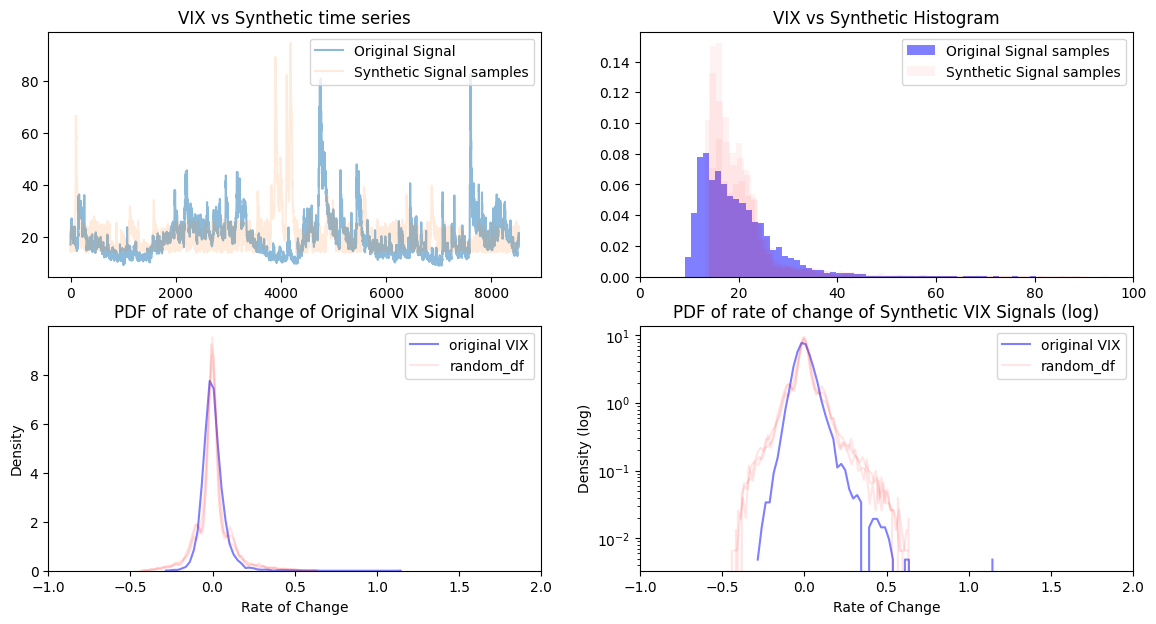

In [503]:
test_generator(simulations=3,random_factor=0.2, skew_factor=2, decay_rate=0.12, decay_length_input=90)

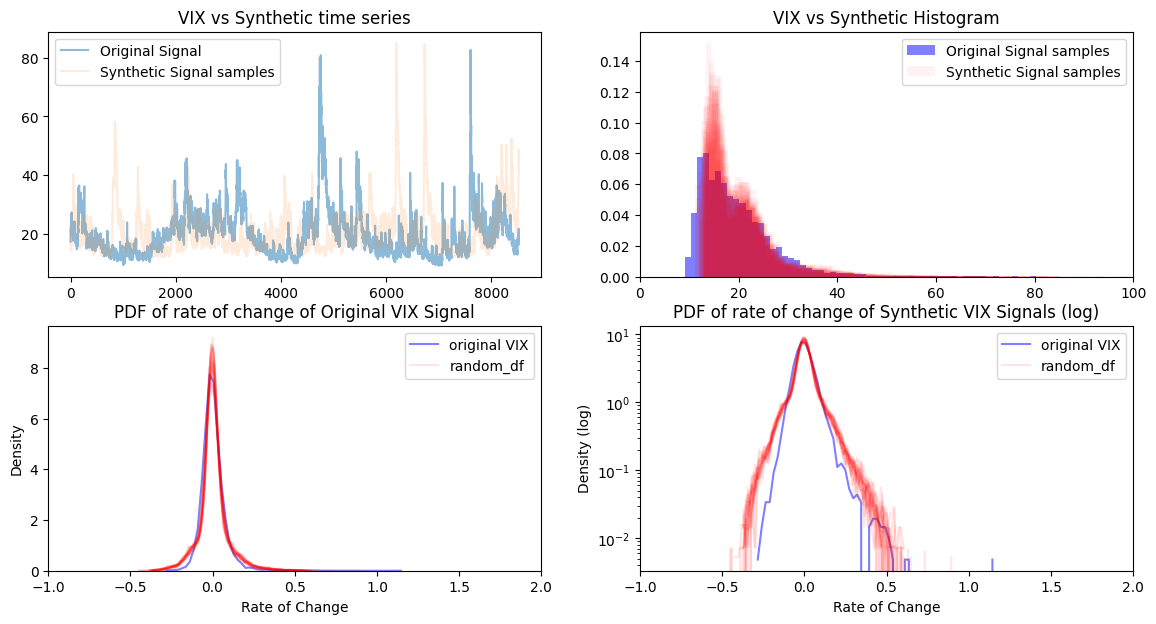

In [527]:
test_generator(simulations=20,random_factor=0.166, skew_factor=1.66, decay_rate=0.166, decay_length_input=30)

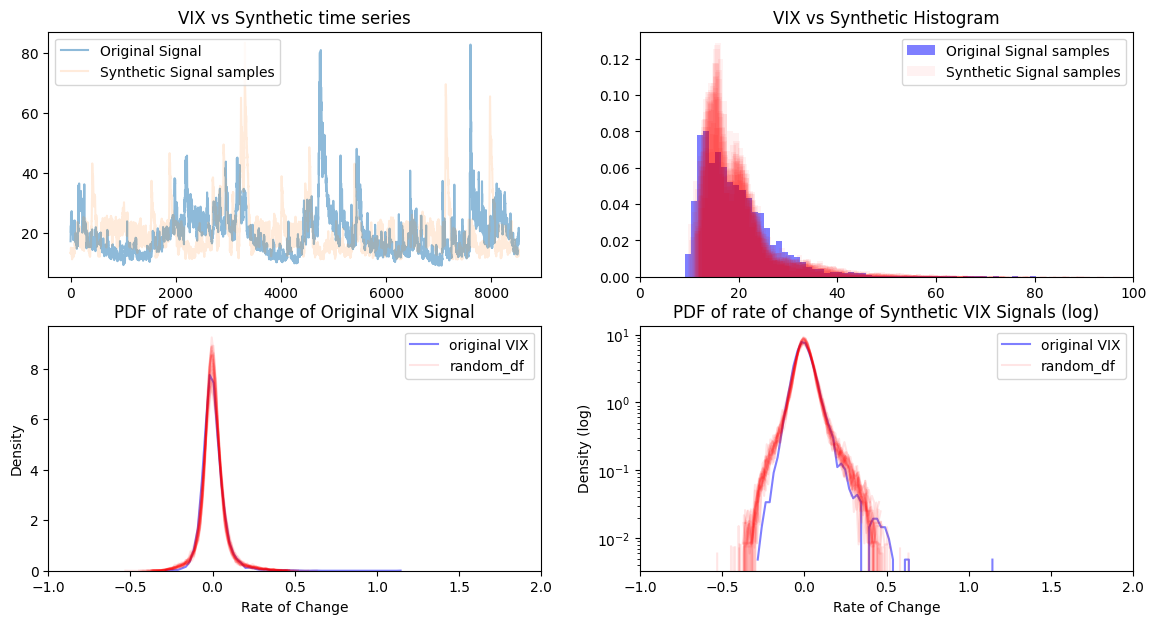

In [526]:
test_generator(simulations=20,random_factor=0.15, skew_factor=1.4, decay_rate=0.075, decay_length_input=60)

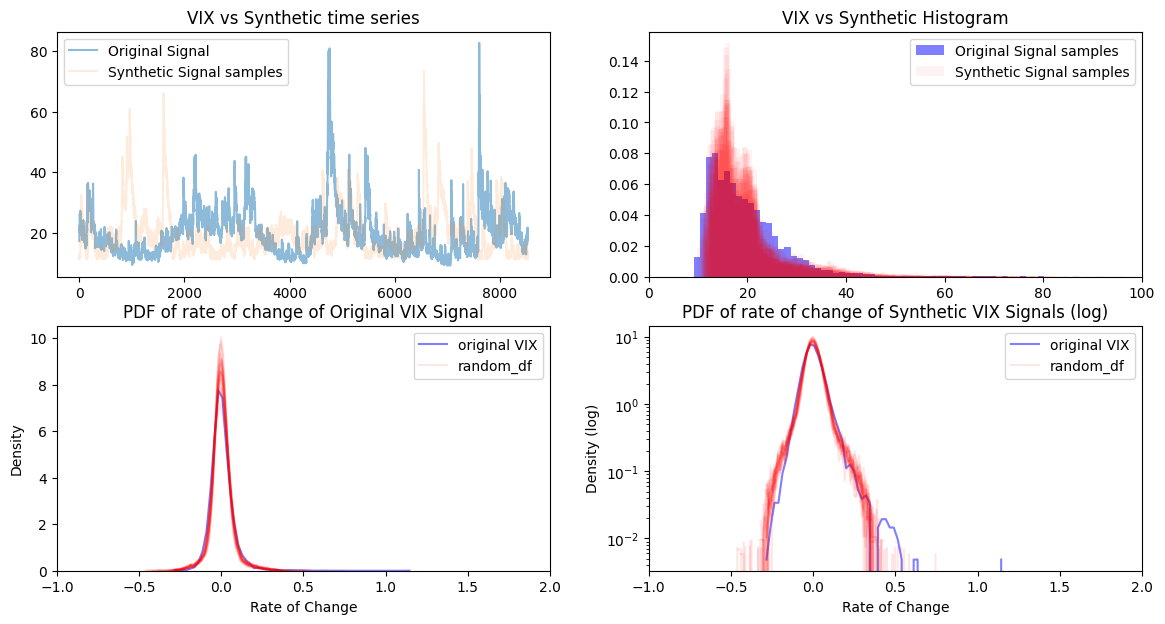

In [525]:
test_generator(simulations=20,random_factor=0.15, skew_factor=1.4, decay_rate=0.03, decay_length_input=60, impact_factor=3)

In [ ]:
test_generator(simulations=20,random_factor=0.15, skew_factor=1.4, decay_rate=0.03, decay_length_input=60, impact_factor=3)